<a href="https://colab.research.google.com/github/Jarcos09/Tareas/blob/main/Metricas_A01795941.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎓 **Inteligencia Artificial Aplicada**

## 🤖 **Análisis de grandes volúmenes de datos (Gpo 10)**

### 🏛️ Tecnológico de Monterrey

#### 👨‍🏫 **Profesor titular :** Dr. Iván Olmos Pineda
#### 👩‍🏫 **Profesor asistente :** Verónica Sandra Guzmán de Valle

### 📊 **Actividad 4 | Métricas de calidad de resultados**

#### 📅 **08 de junio de 2025**

🧑‍💻 **A01795941 :** Juan Carlos Pérez Nava




In [62]:
# Módulos del sistema para manejo de rutas
import os
import sys

# Definición del path para incluir una librería personalizada
module_path = os.path.abspath(os.path.join('proyectos/librerias'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Importación de módulos gráficos personalizados
from graficas import *

# Importación de PySpark para manipulación y análisis de datos
from pyspark.sql import (
    SparkSession, DataFrame
)
from pyspark.sql.types import (
    StructType, StructField, StringType, IntegerType, DoubleType
)
from pyspark.sql.functions import (
    col, sum, avg, lit, count, when, format_number, round, rand, countDistinct
)
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, QuantileDiscretizer,
    VectorAssembler, StandardScaler, Imputer
)

from pyspark.ml.feature import RFormula
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.clustering import KMeans

from pyspark.ml.evaluation import(    MulticlassClassificationEvaluator, ClusteringEvaluator
    )

from pyspark.ml.tuning import (
    ParamGridBuilder, CrossValidator
)

# Importación de librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librería para la integración con Kaggle
import kagglehub

# Manipulación de datos con Pandas
import pandas as pd

# Funciones de programación funcional
from functools import reduce

In [2]:
path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")
print("Path to dataset files:", path)

Path to dataset files: /home/jarcos/.cache/kagglehub/datasets/sobhanmoosavi/us-accidents/versions/13


In [3]:
# Creación de una sesión de Spark
# Se configura el modo "local[*]" para usar todos los núcleos disponibles en la máquina
# Se asigna un nombre a la aplicación y se configuran los límites de memoria para el driver y los ejecutores

spark = SparkSession.builder.master("local[*]").appName("metricas").config("spark.driver.memory", "40g").config("spark.executor.memory", "20g").getOrCreate()
df_accident = spark.read.option("header", True).option("inferSchema", True).csv(path)
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/07 20:08:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# **1 - Construcción de la muestra M**

**Etapa 1: Feature Engineering y Transformers**

A lo largo de las actividades, se han realizado particiones considerando, en primer lugar, la severidad del accidente y, posteriormente, las condiciones climáticas. En este ejercicio se analizará la frecuencia de dichas particiones para identificar combinaciones que permitan una distribución homogénea. Por ello, se revisará el estado actual de estos subconjuntos.


In [4]:
df_accident.select("Severity").groupBy("Severity").count().orderBy("Severity").show()

+--------+-------+
|Severity|  count|
+--------+-------+
|       1|  67366|
|       2|6156981|
|       3|1299337|
|       4| 204710|
+--------+-------+



In [5]:
df_accident.filter(col("Severity") == "1").select("Weather_Condition").groupBy("Weather_Condition").count().orderBy(col("count").desc()).show(8)

+-----------------+-----+
|Weather_Condition|count|
+-----------------+-----+
|             Fair|34359|
|    Mostly Cloudy|10676|
|           Cloudy| 7985|
|    Partly Cloudy| 6820|
|       Light Rain| 2338|
|             NULL|  954|
|              Fog|  662|
|             Rain|  458|
+-----------------+-----+
only showing top 8 rows



In [6]:
df_accident.filter(col("Severity") == "2").select("Weather_Condition").groupBy("Weather_Condition").count().orderBy(col("count").desc()).show(8)

+-----------------+-------+
|Weather_Condition|  count|
+-----------------+-------+
|             Fair|2226576|
|    Mostly Cloudy| 792735|
|           Cloudy| 692929|
|    Partly Cloudy| 548760|
|            Clear| 536971|
|       Light Rain| 270162|
|         Overcast| 248938|
|             NULL| 134781|
+-----------------+-------+
only showing top 8 rows



In [7]:
df_accident.filter(col("Severity") == "3").select("Weather_Condition").groupBy("Weather_Condition").count().orderBy(col("count").desc()).show(8)

+-----------------+------+
|Weather_Condition| count|
+-----------------+------+
|            Clear|244956|
|             Fair|240084|
|    Mostly Cloudy|189229|
|    Partly Cloudy|127692|
|         Overcast|119946|
|           Cloudy| 93340|
|       Light Rain| 71097|
| Scattered Clouds| 66037|
+-----------------+------+
only showing top 8 rows



In [8]:
df_accident.filter(col("Severity") == "4").select("Weather_Condition").groupBy("Weather_Condition").count().orderBy(col("count").desc()).show(8)

+-----------------+-----+
|Weather_Condition|count|
+-----------------+-----+
|             Fair|59783|
|            Clear|26479|
|    Mostly Cloudy|23555|
|           Cloudy|22828|
|    Partly Cloudy|15700|
|         Overcast|13867|
|       Light Rain| 9360|
|             NULL| 7429|
+-----------------+-----+
only showing top 8 rows



In [9]:
# Definición de las columnas clave que serán utilizadas para el análisis y particionamiento
columnas_clave = ["Temperature(F)","Weather_Condition","Severity","Humidity(%)",
                  "Pressure(in)", "Wind_Direction","Wind_Speed(mph)","Precipitation(in)",
                  "Crossing","Junction","Railway","Roundabout","Stop","Sunrise_Sunset",
                  "Traffic_Calming","Traffic_Signal"]

# Escritura del DataFrame en formato Parquet, particionando por las columnas "Severity" y "Weather_Condition"
df_particionada = df_accident.select(columnas_clave)
df_particionada.write.mode("overwrite").partitionBy("Severity","Weather_Condition").parquet("us_accidents_partitioned")

Para generar una partición homogénea con una cantidad significativa de registros, se propone excluir las severidades 1 y 4, ya que representan menos del 1% y 2% del conjunto total, respectivamente. Posteriormente, se seleccionan las condiciones climáticas más predominantes en los accidentes de las severidades restantes, tomando 10,000 registros de cada una, con el objetivo de garantizar condiciones uniformes en cada partición.

In [10]:
# Definir la cantidad de registros a tomar por cada condición climática
registros = {
    "Fair": 10000,
    "Clear": 10000,
    "Mostly Cloudy": 10000,
    "Cloudy": 10000,
    "Partly Cloudy": 10000,
    "Overcast": 10000,
    "Light Rain": 10000
}

# Obtener la lista de condiciones climáticas disponibles en el diccionario de registros
weather_conditions = list(registros.keys())

# Definir las severidades de interés
severidades = [{'Severity': 2}, {'Severity': 3}]

# Crear un diccionario para almacenar los DataFrames filtrados y limitados
dfs = {}

# Generar un DataFrame por cada valor de severidad con el filtro y límite de condiciones climáticas
for severidad in severidades:

    clave = f"Severity_{severidad['Severity']}"

    # Filtrar el DataFrame para mantener solo las filas con la severidad actual y las condiciones climáticas definidas
    df_filtrado = df_particionada.filter(
        (df_particionada["Severity"] == severidad["Severity"]) &
        (df_particionada["Weather_Condition"].isin(weather_conditions))
    )

    # Aplicar el límite de registros por cada condición climática
    df_limitado = df_filtrado.groupBy("Weather_Condition").applyInPandas(
        lambda pdf: pdf.iloc[:registros.get(pdf.iloc[0]["Weather_Condition"], len(pdf))],  # Selecciona hasta 10,000 registros por condición
        schema=df_filtrado.schema  # Mantiene la estructura original del DataFrame
    )

    # Guardar el DataFrame filtrado y limitado en el diccionario
    dfs[clave] = df_limitado

# Obtener las claves generadas en el diccionario de DataFrames
claves = dfs.keys()

In [11]:
# Unir todos los DataFrames en uno solo
df_muestra = reduce(DataFrame.unionAll, dfs.values())

# Contar registros totales para verificar
print(f"Total de registros en el DataFrame final: {df_muestra.count()}")


Total de registros en el DataFrame final: 140000


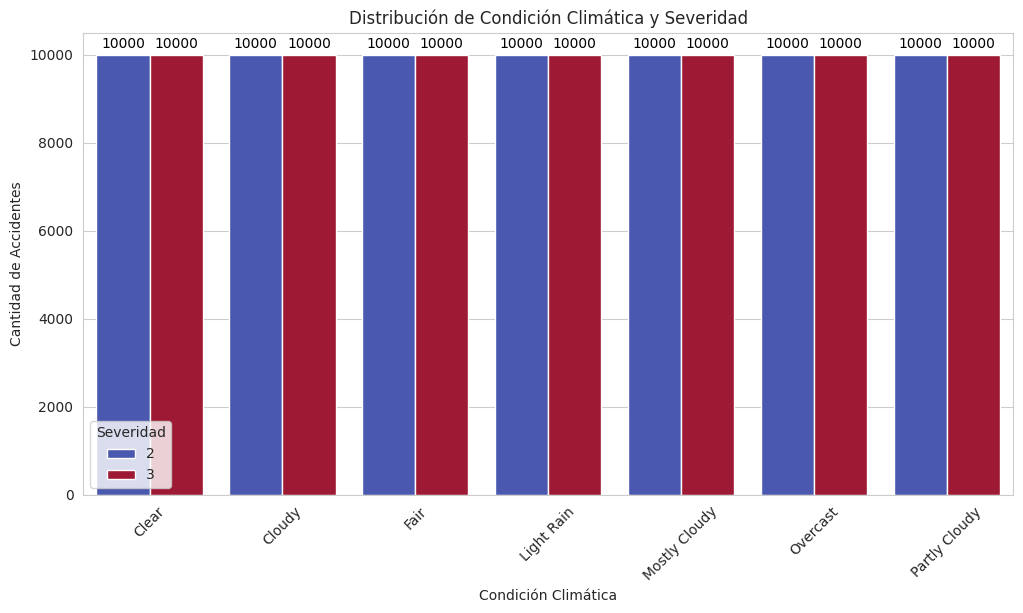

In [12]:
# Convertir a Pandas DataFrame
muestra_pd = df_muestra.select("Severity", "Weather_Condition").toPandas()

# Configuración de estilo
sns.set_style("whitegrid")

# Crear la tabla de frecuencia
tabla_frecuencia = muestra_pd.groupby(["Weather_Condition", "Severity"]).size().reset_index(name="Count")

# Crear el gráfico
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="Weather_Condition", y="Count", hue="Severity", data=tabla_frecuencia, palette="coolwarm")

# Agregar los valores en cada barra
for bars in ax.containers:
    ax.bar_label(bars, fmt='%d', label_type='edge', fontsize=10, color='black', padding=3)

# Configurar etiquetas y título
plt.xticks(rotation=45)
plt.xlabel("Condición Climática")
plt.ylabel("Cantidad de Accidentes")
plt.title("Distribución de Condición Climática y Severidad")

# Ajustar la leyenda
plt.legend(title="Severidad")

# Mostrar el gráfico
plt.show()


**Etapa 2: Procesamiento y Limpieza del Conjunto de Datos**


In [13]:
# Función para obtener un resumen de valores nulos en un DataFrame de PySpark
def obten_nulos(particion):

  print(f"📊 Total de filas en la partición: {particion.count()}")
  print(f"🗂️ Número de columnas en la partición: {len(particion.columns)}")

  info_nulos = {}
  cols_nulos = {}
  total_rows = particion.count()
  registros_totales = particion.count()

  # Contar valores nulos por columna y almacenarlos en un DataFrame temporal

  cols_nulos = particion.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in particion.columns]
    )

  # Convertir los resultados en un diccionario para fácil acceso
  info_nulos = {c: cols_nulos.select(c).collect()[0][0] for c in particion.columns}

  # Filtrar solo las columnas con valores nulos y calcular el porcentaje de nulos
  cols_nulos = {c: {"count": v, "percent": (v / total_rows) * 100} for c, v in info_nulos.items() if v > 0}

  # Validar si existen columnas con valores nulos
  if not cols_nulos:
        print("✅ No existen valores nulos en la partición.")
        return

  # Crear una lista con los resultados para construir un DataFrame
  listado = [(key, value['count'], value['percent']) for key, value in cols_nulos.items()]

  # Definir el esquema del DataFrame para almacenar el resumen de valores nulos
  schema = StructType([
    StructField("Columna", StringType(), True),
    StructField("Total de nulos", IntegerType(), True),
    StructField("Porcentaje", DoubleType(), True)
  ])

  df_resumen_nulos = spark.createDataFrame(listado, schema=schema)

  for col_name in [c for c, t in df_resumen_nulos.dtypes if t == "double"]:
      df_resumen_nulos = df_resumen_nulos.withColumn(col_name, round(df_resumen_nulos[col_name], 2))

  # Ordenar el DataFrame por el número de valores nulos en orden descendente y mostrarlo en consola
  df_resumen_nulos.orderBy(col("Total de nulos").desc()).show(truncate=False)

In [14]:
# Función para imputar valores faltantes en una partición del conjunto de datos
def imputacion_valores(particion):
    print("✅ Se realiza la imputación utilizando los siguientes valores:\n")

    # Obtener las modas (valores más frecuentes) de las variables categóricas
    moda_Weather = particion.groupBy("Weather_Condition").count().orderBy(col("count").desc()).first()["Weather_Condition"]
    moda_wub = particion.groupBy("Wind_Direction").count().orderBy(col("count").desc()).first()["Wind_Direction"]
    moda_Sunset = particion.groupBy("Sunrise_Sunset").count().orderBy(col("count").desc()).first()["Sunrise_Sunset"]

    # Obtener promedios de las variables numéricas para imputación
    media_Temperature = particion.select(round(avg(col("Temperature(F)")), 2).alias("avg_temp")).collect()[0][0]
    media_Humidity = particion.select(round(avg(col("Humidity(%)")), 2).alias("avg_humidity")).collect()[0][0]
    media_Precipitation = particion.select(round(avg(col("Precipitation(in)")), 2).alias("avg_precipitation")).collect()[0][0]
    media_Pressure = particion.select(round(avg(col("Pressure(in)")), 2).alias("Pressure(in)")).collect()[0][0]
    media_Wind_Speed = particion.select(round(avg(col("Wind_Speed(mph)")), 2).alias("Wind_Speed(mph)")).collect()[0][0]



    # Imprimir valores calculados correctamente
    print(f"🌡️ Temperatura promedio: {media_Temperature}")
    print(f"💧 Humedad promedio: {media_Humidity}")
    print(f"🌧️ Precipitación promedio: {media_Precipitation}")
    print(f"🌬️ Velocidad del viento promedio: {media_Wind_Speed}")

    print(f"☁️ Condición meteorológica más frecuente: {moda_Weather}")
    print(f"🌬️ Dirección del viento más frecuente: {moda_wub}")
    print(f"🌅 Hora de atardecer más frecuente: {moda_Sunset}")

    # Aplicar imputación de valores numéricos con la estrategia de promedio
    imputer_num = Imputer(
         inputCols=["Temperature(F)", "Humidity(%)", "Precipitation(in)", "Wind_Speed(mph)","Pressure(in)"],
         outputCols=["Temperature(F)", "Humidity(%)", "Precipitation(in)", "Wind_Speed(mph)","Pressure(in)"]
    ).setStrategy("mean")

    particion = imputer_num.fit(particion).transform(particion)

    # Imputación de valores categóricos utilizando la moda
    particion = particion.na.fill({
        "Weather_Condition": moda_Weather,
        "Wind_Direction": moda_wub,
        "Sunrise_Sunset": moda_Sunset
    })

    print("\n🔍 Se validan nuevamente los valores nulos para corroborar la imputación.\n")

    obten_nulos(particion)

    for col_name in [c for c, t in particion.dtypes if t == "double"]:
      particion = particion.withColumn(col_name, round(particion[col_name], 1))

    return particion

Se identifican las columnas con valores nulos y, posteriormente, se aplican estrategias para su tratamiento, como la imputación de datos faltantes.

In [15]:
obten_nulos(df_muestra)

📊 Total de filas en la partición: 140000
🗂️ Número de columnas en la partición: 16


+-----------------+--------------+----------+
|Columna          |Total de nulos|Porcentaje|
+-----------------+--------------+----------+
|Precipitation(in)|78852         |56.32     |
|Wind_Speed(mph)  |15836         |11.31     |
|Humidity(%)      |952           |0.68      |
|Temperature(F)   |629           |0.45      |
|Wind_Direction   |312           |0.22      |
|Sunrise_Sunset   |290           |0.21      |
|Pressure(in)     |258           |0.18      |
+-----------------+--------------+----------+



In [16]:
muestra_imp = imputacion_valores(df_muestra)

✅ Se realiza la imputación utilizando los siguientes valores:



🌡️ Temperatura promedio: 65.22
💧 Humedad promedio: 69.46
🌧️ Precipitación promedio: 0.01
🌬️ Velocidad del viento promedio: 8.15
☁️ Condición meteorológica más frecuente: Cloudy
🌬️ Dirección del viento más frecuente: Calm
🌅 Hora de atardecer más frecuente: Day



🔍 Se validan nuevamente los valores nulos para corroborar la imputación.



📊 Total de filas en la partición: 140000
🗂️ Número de columnas en la partición: 16


✅ No existen valores nulos en la partición.


Para detectar valores atípicos en las columnas numéricas seleccionadas, se utiliza el método del rango intercuartílico (IQR), que permite identificar aquellos valores que se desvían del rango esperado en cada columna.

In [17]:
outliers = calcular_IQR(muestra_imp,['Precipitation(in)','Temperature(F)','Humidity(%)','Wind_Speed(mph)','Pressure(in)'])
outliers

,IQR,Límite Inf.,Límite Sup.
Columna,,,
Precipitation(in),0.0,0.00,0.00
Temperature(F),20.0,25.90,105.90
Humidity(%),30.0,11.00,131.00
Wind_Speed(mph),5.4,-3.10,18.50
Pressure(in),0.3,29.35,30.55


In [18]:
for index, row in outliers.iterrows():
    columna = index
    limite_inf = row["Límite Inf."]
    limite_sup = row["Límite Sup."]

    columnas_IQR = f"`{columna}`"

    # Aplicar una transformación a la columna para reemplazar valores atípicos
    # Si un valor está fuera de los límites establecidos, se sustituye por el promedio de la columna
    # En caso contrario, se conserva el valor original
    muestra_imp = muestra_imp.withColumn(columna, when((col(columna) < limite_inf) | (col(columna) > limite_sup), muestra_imp.selectExpr(f"avg({columnas_IQR})").collect()[0][0])
        .otherwise(col(columna))
    )


In [19]:
# Se vuelve a calcular el rango intercuartílico (IQR) para verificar cambios
outliers = calcular_IQR(muestra_imp,['Precipitation(in)','Temperature(F)','Humidity(%)','Wind_Speed(mph)','Pressure(in)'])
outliers

,IQR,Límite Inf.,Límite Sup.
Columna,,,
Precipitation(in),0.000000,0.000000,0.000000
Temperature(F),19.900000,26.150000,105.750000
Humidity(%),30.000000,11.000000,131.000000
Wind_Speed(mph),4.200000,-1.300000,15.500000
Pressure(in),0.298681,29.353298,30.548021


Se imprime un resumen de las estadísticas descriptivas de los valores numéricos, proporcionando métricas clave para su verficacion.

In [20]:
muestra_imp.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+--------------+------------------+--------------------+--------------+
|summary|    Temperature(F)|Weather_Condition|          Severity|       Humidity(%)|      Pressure(in)|Wind_Direction|   Wind_Speed(mph)|   Precipitation(in)|Sunrise_Sunset|
+-------+------------------+-----------------+------------------+------------------+------------------+--------------+------------------+--------------------+--------------+
|  count|            140000|           140000|            140000|            140000|            140000|        140000|            140000|              140000|        140000|
|   mean| 65.79846440924454|             NULL|               2.5| 69.63205350112243|29.937271497784945|          NULL| 7.859640492423623|1.688425306122476E-4|          NULL|
| stddev|14.371687150802224|             NULL|0.5000017857238522|20.563527846658314|0.1915637539781627|          NULL|3.8651214279

Se crea el vector de características utilizando RFormula, que permite transformar los datos de manera estructurada para su uso en modelos de aprendizaje automático.

In [21]:
# "Severity ~ ." indica que 'Severity' es la variable dependiente y el resto son predictoras
rForm = RFormula(formula="Severity ~ .")

# Ajustar el modelo RFormula al DataFrame de entrada
muestra_RF = rForm.fit(muestra_imp)

# Transformar el DataFrame para preparar los datos según la fórmula aplicada
muestra_preparadaRF = muestra_RF.transform(muestra_imp)

# Mostrar las primeras 5 filas del DataFrame transformado
muestra_preparadaRF.show(5)

+--------------+-----------------+--------+-----------+------------------+--------------+---------------+-----------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+--------------------+-----+
|Temperature(F)|Weather_Condition|Severity|Humidity(%)|      Pressure(in)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Crossing|Junction|Railway|Roundabout| Stop|Sunrise_Sunset|Traffic_Calming|Traffic_Signal|            features|label|
+--------------+-----------------+--------+-----------+------------------+--------------+---------------+-----------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+--------------------+-----+
|          49.0|           Cloudy|       2|      100.0|29.801319285714076|             E|           10.0|              0.0|   false|   false|  false|     false|false|           Day|          false|         false|(42,[0,2,7,8,32,3...|  2.0|
|          63.0|           Cloudy|      

In [22]:
muestra_preparadaRF.printSchema()

root
 |-- Temperature(F): double (nullable = true)
 |-- Weather_Condition: string (nullable = false)
 |-- Severity: integer (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Wind_Direction: string (nullable = false)
 |-- Wind_Speed(mph): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)
 |-- Crossing: boolean (nullable = true)
 |-- Junction: boolean (nullable = true)
 |-- Railway: boolean (nullable = true)
 |-- Roundabout: boolean (nullable = true)
 |-- Stop: boolean (nullable = true)
 |-- Sunrise_Sunset: string (nullable = false)
 |-- Traffic_Calming: boolean (nullable = true)
 |-- Traffic_Signal: boolean (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)



# **2 - Construcción Train – Test**


Se implementarán dos métodos para la preparación del conjunto de entrenamiento y prueba:
* **Muestreo aleatorio simple**: Se realizará una división 80-20, asignando el 80% de los datos al entrenamiento y el 20% a la prueba.
* **Muestreo estratificado**: Se organizarán los datos en función de la severidad y las condiciones climáticas, asegurando una representación equilibrada en ambos conjuntos.


In [23]:
print("Número de registros: " + str(muestra_preparadaRF.count()))

Número de registros: 140000


**Muestreo aleatorio simple**:

Cuando Spark hace operaciones como joins, groupBy o agregaciones, necesita mover y organizar los datos entre diferentes nodos. A esto se le llama shuffle, y el número de particiones define cómo se distribuyen esos datos.
- Si hay pocas particiones, cada tarea tendrá muchos datos, lo que puede hacer que el proceso sea más lento.
- Si hay demasiadas particiones, se crean muchas pequeñas tareas, lo que puede generar más carga y reducir la eficiencia


In [24]:
spark.conf.set("spark.sql.shuffle.partitions", "8")
train_data_aleatorio ,test_data_aleatorio = muestra_preparadaRF.randomSplit([0.7,0.3], seed = 42)

# Contar instancias en cada conjunto
train_count = train_data_aleatorio.count()
test_count = test_data_aleatorio.count()
total_count = train_count + test_count

# Calcular porcentajes
train_percentage = (train_count / total_count) * 100
test_percentage = (test_count / total_count) * 100

# Imprimir resultados con porcentaje
print(f"""📊 Resumen de la división de datos
🔹 Conjunto de entrenamiento: {train_count:,} instancias ({train_percentage:.2f}%)
🔹 Conjunto de prueba: {test_count:,} instancias ({test_percentage:.2f}%)""")



📊 Resumen de la división de datos
🔹 Conjunto de entrenamiento: 98,333 instancias (70.24%)
🔹 Conjunto de prueba: 41,667 instancias (29.76%)


**Muestreo estratificado**

 El muestreo estratificado es una técnica de selección de datos donde se agrupan las observaciones en estratos antes de extraer una muestra representativa de cada uno, siendo util para:

✅**Garantiza representatividad**: Cada condición climática y nivel de severidad tendrá una proporción similar en la muestra.

✅**Evita sesgos**: Permite que todas las categorías del dataset estén bien representadas.

✅**Mejora la calidad del modelo**: Si las clases están desbalanceadas, esto ayuda a equilibrarlas antes del entrenamiento.


In [25]:
from pyspark.sql.functions import concat, lit
muestra_preparadaRF_stratum = muestra_preparadaRF.withColumn("stratum", concat(muestra_preparadaRF["Weather_Condition"], lit("_"), muestra_preparadaRF["Severity"]))
muestra_preparadaRF_stratum.show(5)

+--------------+-----------------+--------+-----------+------------------+--------------+---------------+-----------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+--------------------+-----+-------+
|Temperature(F)|Weather_Condition|Severity|Humidity(%)|      Pressure(in)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Crossing|Junction|Railway|Roundabout| Stop|Sunrise_Sunset|Traffic_Calming|Traffic_Signal|            features|label|stratum|
+--------------+-----------------+--------+-----------+------------------+--------------+---------------+-----------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+--------------------+-----+-------+
|          87.0|             Fair|       2|       35.0|29.801319285714076|           SSE|            8.0|              0.0|   false|   false|  false|     false|false|           Day|          false|         false|(42,[0,3,7,8,17,3...|  2.0| Fair_2|
|       

In [26]:
muestra_preparadaRF.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [Temperature(F)#3615, Weather_Condition#1908, Severity#272, Humidity(%)#3683, Pressure(in)#3819, Wind_Direction#1909, Wind_Speed(mph)#3751, Precipitation(in)#3547, Crossing#278, Junction#279, Railway#280, Roundabout#281, Stop#282, Sunrise_Sunset#1910, Traffic_Calming#284, Traffic_Signal#285, features#5986 AS features#6010, cast(Severity#272 as double) AS label#6051]
   +- Project [Temperature(F)#3615, Weather_Condition#1908, Severity#272, Humidity(%)#3683, Pressure(in)#3819, Wind_Direction#1909, Wind_Speed(mph)#3751, Precipitation(in)#3547, Crossing#278, Junction#279, Railway#280, Roundabout#281, Stop#282, Sunrise_Sunset#1910, Traffic_Calming#284, Traffic_Signal#285, UDF(struct(Temperature(F), Temperature(F)#3615, onehot_140ecf5feed7, UDF(stridx_662d0e985070#5875, 0), Humidity(%), Humidity(%)#3683, Pressure(in), Pressure(in)#3819, onehot_c70bf8f59430, UDF(stridx_0f41f2b68ebb#5900, 1), Wind_Speed(mph), Wind_Speed(mph)#37

In [27]:
stratum_counts_weather = muestra_preparadaRF_stratum.groupBy("Weather_Condition").count().collect()
stratum_counts_severity = muestra_preparadaRF_stratum.groupBy("Severity").count().collect()

stratum_counts_combinado_a = muestra_preparadaRF_stratum.groupBy("Weather_Condition","Severity").count().collect()
stratum_counts_combinado = muestra_preparadaRF_stratum.groupBy("stratum").count().collect()

print(stratum_counts_weather)
print(stratum_counts_severity)

print(stratum_counts_combinado_a)
print(stratum_counts_combinado)

[Row(Weather_Condition='Fair', count=20000), Row(Weather_Condition='Light Rain', count=20000), Row(Weather_Condition='Cloudy', count=20000), Row(Weather_Condition='Overcast', count=20000), Row(Weather_Condition='Clear', count=20000), Row(Weather_Condition='Partly Cloudy', count=20000), Row(Weather_Condition='Mostly Cloudy', count=20000)]
[Row(Severity=2, count=70000), Row(Severity=3, count=70000)]
[Row(Weather_Condition='Fair', Severity=2, count=10000), Row(Weather_Condition='Light Rain', Severity=2, count=10000), Row(Weather_Condition='Overcast', Severity=2, count=10000), Row(Weather_Condition='Cloudy', Severity=2, count=10000), Row(Weather_Condition='Clear', Severity=2, count=10000), Row(Weather_Condition='Partly Cloudy', Severity=2, count=10000), Row(Weather_Condition='Mostly Cloudy', Severity=2, count=10000), Row(Weather_Condition='Fair', Severity=3, count=10000), Row(Weather_Condition='Light Rain', Severity=3, count=10000), Row(Weather_Condition='Overcast', Severity=3, count=10000

📊 Informe de Distribución de Datos

🔹 Distribución de las Condiciones Climáticas

Cada condición climática tiene 20,000 registros, lo que indica una distribución uniforme en el conjunto de datos. No hay predominancia de ninguna categoría, asegurando una representación equilibrada.

🔹 Gravedad de los Eventos

Los eventos se dividen en dos niveles de severidad (2 y 3), con 70,000 registros asignados a cada uno. Esto muestra un balance entre ambas categorías, evitando sesgos en la severidad de los casos.

🔹 Relación entre Clima y Severidad

Cada condición climática se asocia con 10,000 registros de severidad 2 y 10,000 registros de severidad 3. Este patrón sugiere que la distribución entre condiciones climáticas y severidad es equilibrada, sin tendencias hacia un nivel de severidad específico.

🔹 Estratificación del Clima y Severidad

Los estratos creados mediante la combinación de Condición Climática y Severidad (Weather_Condition + Severity) tienen 10,000 registros cada uno, asegurando una distribución simétrica dentro del conjunto de datos.


In [28]:
from pyspark.sql.functions import col, count

# Calcular el total de registros
total_count = muestra_preparadaRF_stratum.count()

# Calcular la fracción de muestreo (por ejemplo, para obtener un 30% del total)
stratum_fractions_df = muestra_preparadaRF_stratum.groupBy("stratum") \
    .agg((count("*") / total_count * 0.3).alias("fraction"))

# Convertir el DataFrame a un diccionario para sampleBy()
stratum_fractions = {row["stratum"]: row["fraction"] for row in stratum_fractions_df.collect()}

In [29]:
test_data_stratum = muestra_preparadaRF_stratum.sample(fraction=0.3, seed=42)
train_data_stratum = muestra_preparadaRF_stratum.exceptAll(test_data_stratum)


# Contar instancias en cada conjunto
train_count = test_data_stratum.count()
test_count = train_data_stratum.count()
total_count = train_count + test_count

# Calcular porcentajes
train_percentage = (train_count / total_count) * 100
test_percentage = (test_count / total_count) * 100


# Imprimir resultados con porcentaje
print(f"""📊 Resumen de la división de datos
🔹 Conjunto de entrenamiento: {train_count:,} instancias ({train_percentage:.2f}%)
🔹 Conjunto de prueba: {test_count:,} instancias ({test_percentage:.2f}%)""")


# Mostrar registros de cada conjunto
train_data_stratum.show(5)
test_data_stratum.show(5)


📊 Resumen de la división de datos
🔹 Conjunto de entrenamiento: 41,980 instancias (29.99%)
🔹 Conjunto de prueba: 98,019 instancias (70.01%)


+--------------+-----------------+--------+-----------+------------------+--------------+---------------+-----------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+--------------------+-----+-------+
|Temperature(F)|Weather_Condition|Severity|Humidity(%)|      Pressure(in)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Crossing|Junction|Railway|Roundabout| Stop|Sunrise_Sunset|Traffic_Calming|Traffic_Signal|            features|label|stratum|
+--------------+-----------------+--------+-----------+------------------+--------------+---------------+-----------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+--------------------+-----+-------+
|          89.0|             Fair|       2|       24.0|29.801319285714076|           SSE|           14.0|              0.0|   false|   false|  false|     false|false|           Day|          false|         false|(42,[0,3,7,8,17,3...|  2.0| Fair_2|
|       

+--------------+-----------------+--------+-----------+------------------+--------------+---------------+-----------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+--------------------+-----+-------+
|Temperature(F)|Weather_Condition|Severity|Humidity(%)|      Pressure(in)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Crossing|Junction|Railway|Roundabout| Stop|Sunrise_Sunset|Traffic_Calming|Traffic_Signal|            features|label|stratum|
+--------------+-----------------+--------+-----------+------------------+--------------+---------------+-----------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+--------------------+-----+-------+
|          85.0|             Fair|       2|       44.0|29.801319285714076|             S|           10.0|              0.0|   false|   false|  false|     false|false|           Day|          false|         false|(42,[0,3,7,8,27,3...|  2.0| Fair_2|
|       

# **3 - Selección de métricas para medir calidad de resultados**


El modelo que mostró el mejor desempeño en el ejercicio anterior fue **`RandomForestClassifier`**, por lo que se utilizarán las siguientes métricas para evaluar su rendimiento:

✅ **Accuracy**: Indica el porcentaje de predicciones correctas sobre el total de instancias.

✅ **Precision**: Evalúa qué tan preciso es el modelo en la clasificación de cada categoría, reduciendo falsas asignaciones.

✅ **Recall**: Mide cuántas instancias de cada clase fueron correctamente identificadas por el modelo.

✅ **F1-Score**: Combina precisión y recall en una sola métrica, equilibrando la evaluación entre todas las clases.

In [63]:
accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_score = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

silhouette = ClusteringEvaluator(featuresCol="features", predictionCol="label", metricName="silhouette")

# **4 - Entrenamiento de Modelos de Aprendizaje**


Se utilizará el modelo RandomForestClassifier, y la estrategia de entrenamiento considerará los siguientes aspectos:

🔹 Preprocesamiento de Datos

✅ Se aplicó selección de características para identificar las variables más representativas del modelo.

✅ Se segmentaron los datos para garantizar una distribución equilibrada, evitando que el modelo favorezca una característica predominante.

✅ Se realizó imputación de datos faltantes para mejorar el rendimiento del modelo y reducir la pérdida de información.

✅ Se generó la columna 'features' a partir del vector de características, y 'label' como la variable objetivo, utilizando RFormula.

✅ Se aplicó muestreo aleatorio simple y estratificado para evaluar distintas distribuciones y determinar cuál ofrece los mejores resultados.


🔹 Entrenamiento del Modelo

✅ Se configurará un bosque de 50 árboles (numTrees=50) para mejorar la capacidad de generalización del modelo.

✅ Se establecerá una profundidad máxima de 10 niveles (maxDepth=10) para prevenir el sobreajuste.

✅ Se empleará la selección automática de características (featureSubsetStrategy="auto") para optimizar la eficiencia del aprendizaje.

✅ Se utilizará "entropy" como criterio de división, maximizando la información en cada partición del árbol.

✅ Se aplicará un subsampling del 80% (subsamplingRate=0.8) para reducir la varianza y mejorar la estabilidad del modelo.

🔹 Ajuste de Hiperparámetros

✅ Se realizará validación cruzada para optimizar los hiperparámetros numTrees, maxDepth y subsamplingRate, utilizando el conjunto de datos estratificados, con el objetivo de mejorar el rendimiento del modelo.

✅ La evaluación se realizará utilizando la métrica de Accuracy, que permitirá medir la calidad de las predicciones y la eficacia del modelo.

✅ Se ajustarán los hiperparámetros óptimos obtenidos durante el proceso de validación, asegurando la mejor configuración posible.


# Aplicación del modelo de aprendizaje supervisado

In [31]:
# 🌳 Definir el modelo de Random Forest Regressor
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='label',
    numTrees=50,
    maxDepth=10,
    featureSubsetStrategy="auto",
    impurity="entropy",
    subsamplingRate=0.8
)

In [32]:
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 50, 100]).\
            addGrid(rf.maxDepth, [5, 10, 15]).\
            addGrid(rf.subsamplingRate, [0.7, 0.8, 0.9]).build()

In [33]:
crossval = CrossValidator(
    estimator=rf,  # Modelo a evaluar
    estimatorParamMaps=paramGrid,  # Hiperparámetros
    evaluator=accuracy,  # Métrica de evaluación
    numFolds=3  # Número de particiones para la validación cruzada
)

# 🏋️‍♂️ **Entrenar el modelo con validación cruzada**
cv_model = crossval.fit(train_data_stratum)

In [34]:
# Obtener el mejor modelo entrenado
parametros = cv_model.bestModel

# Extraer hiperparámetros optimizados
num_trees = parametros.getNumTrees
max_depth = parametros.getOrDefault("maxDepth")
feature_subset_strategy = parametros.getOrDefault("featureSubsetStrategy")
impurity = parametros.getOrDefault("impurity")
subsampling_rate = parametros.getOrDefault("subsamplingRate")

predictions = cv_model.transform(test_data_aleatorio)
mejor_acc = accuracy.evaluate(predictions)

print(f"✅ Mejor modelo encontrado - Accuracy: {mejor_acc:.4f}")

print(f"""📌 **Hiperparámetros del mejor modelo**
🌲 Número de árboles: {num_trees}
📏 Profundidad máxima: {max_depth}
🔎 Estrategia de selección de características: {feature_subset_strategy}
⚖ Criterio de impureza: {impurity}
📉 Tasa de muestreo: {subsampling_rate}""")

✅ Mejor modelo encontrado - Accuracy: 0.6455
📌 **Hiperparámetros del mejor modelo**
🌲 Número de árboles: 50
📏 Profundidad máxima: 15
🔎 Estrategia de selección de características: auto
⚖ Criterio de impureza: entropy
📉 Tasa de muestreo: 0.9


In [35]:
# 🌳 Definición del modelo Random Forest Regressor
# Utilizando los mejores hiperparámetros obtenidos
# mediante validación cruzada.

rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='label',
    numTrees=num_trees,
    maxDepth=max_depth,
    featureSubsetStrategy= feature_subset_strategy ,
    impurity= impurity,
    subsamplingRate= subsampling_rate
)

In [36]:
# 🏋️ Entrenar el modelo con el conjunto de entrenamiento
rf_model_aleatorio = rf.fit(train_data_aleatorio)
rf_model_estratificado = rf.fit(train_data_stratum)

In [38]:
# Imprimiendo el accuracy de cada modelo con su respectivo test
accuracy_aleatorio = accuracy.evaluate(rf_model_aleatorio.transform(test_data_aleatorio))
accuracy_estratificado = accuracy.evaluate(rf_model_estratificado.transform(train_data_stratum))

precision_aleatorio = precision.evaluate(rf_model_aleatorio.transform(test_data_aleatorio))
precision_estratificado = precision.evaluate(rf_model_estratificado.transform(train_data_stratum))

recall_aleatorio = recall.evaluate(rf_model_aleatorio.transform(test_data_aleatorio))
recall_estratificado = recall.evaluate(rf_model_estratificado.transform(train_data_stratum))

f1_score_aleatorio = f1_score.evaluate(rf_model_aleatorio.transform(test_data_aleatorio))
f1_score_estratificado = f1_score.evaluate(rf_model_estratificado.transform(train_data_stratum))


# 📊 Imprimiendo resultados del modelo
print("\n🔎 Evaluación del Modelo - Comparación de Muestreos 🔍\n")

# 🎯 Accuracy
print(f"✅ Accuracy - Muestreo Aleatorio: {accuracy_aleatorio:.4f} 🎯")
print(f"✅ Accuracy - Muestreo Estratificado: {accuracy_estratificado:.4f} 🎯\n")

# 🎯 Precision
print(f"🎯 Precisión - Muestreo Aleatorio: {precision_aleatorio:.4f} 🔍")
print(f"🎯 Precisión - Muestreo Estratificado: {precision_estratificado:.4f} 🔍\n")

# 🔥 Recall
print(f"🔥 Recall - Muestreo Aleatorio: {recall_aleatorio:.4f} 🚀")
print(f"🔥 Recall - Muestreo Estratificado: {recall_estratificado:.4f} 🚀\n")

# ⚡ F1-Score
print(f"⚡ F1-Score - Muestreo Aleatorio: {f1_score_aleatorio:.4f} ⚖")
print(f"⚡ F1-Score - Muestreo Estratificado: {f1_score_estratificado:.4f} ⚖")



🔎 Evaluación del Modelo - Comparación de Muestreos 🔍

✅ Accuracy - Muestreo Aleatorio: 0.6339 🎯
✅ Accuracy - Muestreo Estratificado: 0.6526 🎯

🎯 Precisión - Muestreo Aleatorio: 0.6782 🔍
🎯 Precisión - Muestreo Estratificado: 0.7001 🔍

🔥 Recall - Muestreo Aleatorio: 0.6339 🚀
🔥 Recall - Muestreo Estratificado: 0.6526 🚀

⚡ F1-Score - Muestreo Aleatorio: 0.6096 ⚖
⚡ F1-Score - Muestreo Estratificado: 0.6307 ⚖


# Aplicación del modelo de aprendizaje no supervisado

In [44]:
# 🔍 Definir el modelo K-Means
# K-Means es un algoritmo de agrupamiento que clasifica los datos en k grupos según su similitud
kmeans = KMeans(
    featuresCol='features',
    k=2,
    seed=42
)

# 🏋️ Entrenar el modelo con los datos escalados
model_kmeans = kmeans.fit(muestra_preparadaRF)

# 🔄 Aplicar el modelo entrenado para hacer predicciones y asignar cada dato a un cluster
kMeans_pred = model_kmeans.transform(muestra_preparadaRF)

# 📊 Mostrar los resultados de la agrupación
kMeans_pred.select('features','label','prediction').show(5,truncate = True)

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(42,[0,3,7,8,17,3...|  2.0|         0|
|(42,[0,3,7,8,17,3...|  2.0|         0|
|(42,[0,3,7,8,27,3...|  2.0|         0|
|(42,[0,3,7,8,27,3...|  2.0|         0|
|(42,[0,3,7,8,27,3...|  2.0|         0|
+--------------------+-----+----------+
only showing top 5 rows



In [65]:
silhouette_score = evaluator.evaluate(kMeans_pred)
sse = model_kmeans.summary.trainingCost

print(f"🔍 Silhouette Score: {silhouette_score:.4f}")
print(f"📉 SSE (Inertia): {sse:.4f}")

kMeans_pred.groupBy("prediction").count().show()

🔍 Silhouette Score: 0.0012
📉 SSE (Inertia): 43067466.9648


+----------+-----+
|prediction|count|
+----------+-----+
|         1|87603|
|         0|52397|
+----------+-----+



# **5 -  Análisis de resultados**


5 Análisis de resultados”, en la cual incluya una profunda reflexión de los resultados alcanzados, identificando sus fortalezas y áreas de oportunidad de los resultados obtenidos.

* **Velasco Rebolledo, J. (2024)**. Machine Learning: Fundamentos, algoritmos y aplicaciones. Editorial Díaz de Santos. Recuperado el 20 de mayo de 2025, de https://elibro.net/es/ereader/consorcioitesm/275096.
* **Apache Software Foundation. (s.f.)**. PySpark ML API Reference. Recuperado el 20 de mayo de 2025, de https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html.


- Purushotham, S., & Tripathy, B. K. (2011, December). Evaluation of classifier models using stratified tenfold cross validation techniques. En International conference on computing and communication systems (pp. 680-690). Berlin, Heidelberg: Springer Berlin Heidelberg. Disponible en Springer o ResearchGate.
- Dietterich, T. G. (2000, June). Ensemble methods in machine learning. En International workshop on multiple classifier systems (pp. 1-15). Berlin, Heidelberg: Springer Berlin Heidelberg. Disponible en Springer.
- Junqué de Fortuny, E., Martens, D., & Provost, F. (2013). Predictive modeling with big data: is bigger really better? Big Data, 1(4), 215-226. Disponible en Mary Ann Liebert.
- Al-Jarrah, O. Y., Yoo, P. D., Muhaidat, S., Karagiannidis, G. K., & Taha, K. (2015). Efficient machine learning for big data: A review. Big Data Research, 2(3), 87-93. Disponible en arXiv o Academia.edu.
- Zhou, L., Pan, S., Wang, J., & Vasilakos, A. V. (2017). Machine learning on big data: Opportunities and challenges. Neurocomputing, 237, 350-361. Disponible en ResearchGate.
